In [ ]:
#### import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import Word
from textblob import TextBlob

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from modAL.models import ActiveLearner
from modAL.models import ActiveLearner

import en_core_web_sm
nlp = en_core_web_sm.load()

%matplotlib inline

In [23]:
original_data = pd.read_csv('../dataset/mohler2_cleaned.csv')
original_data = original_data.drop(labels='Unnamed: 0', axis=1)
original_data = original_data.rename(columns={'question_number':'question_id','question_text':'question','answer_model':'ref_answer','answer_student':'student_answer','score_avg':'grade'})

In [24]:
df = original_data.copy()

#converting to lower case
df['ref_modified'] = df['ref_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['student_modified'] = df['student_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#punctuation removal
df['ref_modified'] = df['ref_modified'].str.replace('[^\w\s]','')
df['student_modified'] = df['student_modified'].str.replace('[^\w\s]','')

#stop word removal
stop = stopwords.words('english')
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


#lemmatisation
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))

df

,question_id,question,ref_answer,student_answer,grade,ref_modified,student_modified
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,3.5,simulate behaviour portion desired software pr...,high risk problem address prototype program ma...
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,simulate behaviour portion desired software pr...,simulate portion desired final product quick e...
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,4.0,simulate behaviour portion desired software pr...,prototype program simulates behavior portion d...
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,simulate behaviour portion desired software pr...,defined specification phase prototype stimulat...
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,simulate behaviour portion desired software pr...,used let user first idea completed program all...
5,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To find problem and errors in a program before...,2.0,simulate behaviour portion desired software pr...,find problem error program finalized
6,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To address major issues in the creation of the...,2.5,simulate behaviour portion desired software pr...,address major issue creation program way accou...
7,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,you can break the whole program into prototype...,5.0,simulate behaviour portion desired software pr...,break whole program prototype program simulate...
8,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To provide an example or model of how the fini...,3.5,simulate behaviour portion desired software pr...,provide example model finished program perfom ...
9,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Simulating the behavior of only a portion of t...,5.0,simulate behaviour portion desired software pr...,simulating behavior portion desired software p...


In [25]:
short_df = df[['question_id','student_answer','student_modified', 'grade','question']]
short_df['status'] = short_df['grade'] >= 3
short_df['status'] = short_df['status'].astype(int)
ques_id_list = list(short_df['question_id'].unique())

# FOR ONE BY ONE QUESTION
# short_df = short_df[short_df['question_id'] == ques_id_list[0]]
# ques_id_list.pop(0)
# ques_id_list
# ======================

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
short_df

,question_id,student_answer,student_modified,grade,question,status
0,1.1,High risk problems are address in the prototyp...,high risk problem address prototype program ma...,3.5,What is the role of a prototype program in pro...,1
1,1.1,To simulate portions of the desired final prod...,simulate portion desired final product quick e...,5.0,What is the role of a prototype program in pro...,1
2,1.1,A prototype program simulates the behaviors of...,prototype program simulates behavior portion d...,4.0,What is the role of a prototype program in pro...,1
3,1.1,Defined in the Specification phase a prototype...,defined specification phase prototype stimulat...,5.0,What is the role of a prototype program in pro...,1
4,1.1,It is used to let the users have a first idea ...,used let user first idea completed program all...,3.0,What is the role of a prototype program in pro...,1
5,1.1,To find problem and errors in a program before...,find problem error program finalized,2.0,What is the role of a prototype program in pro...,0
6,1.1,To address major issues in the creation of the...,address major issue creation program way accou...,2.5,What is the role of a prototype program in pro...,0
7,1.1,you can break the whole program into prototype...,break whole program prototype program simulate...,5.0,What is the role of a prototype program in pro...,1
8,1.1,To provide an example or model of how the fini...,provide example model finished program perfom ...,3.5,What is the role of a prototype program in pro...,1
9,1.1,Simulating the behavior of only a portion of t...,simulating behavior portion desired software p...,5.0,What is the role of a prototype program in pro...,1


In [27]:
# short_df['word_count'] = short_df['student_answer'].apply(lambda x: dict(Counter(x.split())))

# counting unique words in every student's answer
CV = CountVectorizer()
student_answer_count_vector = CV.fit_transform(short_df['student_modified'])
student_answer_count_vector = student_answer_count_vector.toarray()

X = student_answer_count_vector
Y = short_df['status'].values

In [28]:
#getting the seed index
classes = short_df['status'].unique()
seed_index = []
for i in classes:
    seed_index.append(short_df['status'][short_df['status']==i].index[0])
seed_index

[0, 5]

In [30]:
act_data = short_df.copy()
accuracy_list = []

# initialising
train_idx = seed_index
X_train = X[train_idx]
y_train = Y[train_idx]
 
# generating the pool
X_pool = np.delete(X, train_idx, axis=0)
y_pool = np.delete(Y, train_idx)

act_data = act_data.drop(axis=0,index = train_idx)
act_data.reset_index(drop = True,inplace=True)


# initializing the active learner
# lr = LogisticRegression()
nb = MultinomialNB()
learner = ActiveLearner(
#     estimator = lr,
    estimator = nb,
#     estimator = RandomForestClassifier(n_estimators=5),
#     estimator=KNeighborsClassifier(n_neighbors=3),
    X_training=X_train, y_training=y_train
)

# pool-based sampling
n_queries = 40
for idx in range(n_queries):
    query_idx, query_instance = learner.query(X_pool)
    print("\nQ: ", act_data.loc[int(query_idx),'question'])
    print("A: ",act_data.loc[int(query_idx),'student_answer'])
    print("Actual grade: ",y_pool[query_idx].reshape(1, ))
#     print(learner.sigma_)
    print ("Class probabilities: ",learner.predict_proba(X_pool[query_idx].reshape(1, -1)))
    human_label = int(input("\nGive me a grade 0 or 1:"))
    learner.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=[human_label]
    )
    
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)
    
    act_data = act_data.drop(axis=0,index = query_idx)
    act_data.reset_index(drop=True, inplace=True)
    
    accuracy_list.append(learner.score(X,Y))
    print('Accuracy after query no. %d: %f' % (idx+1, learner.score(X, Y)))


Q:  How many constructors can be created for a class?
A:  1 
Actual grade:  [0]
Class probabilities:  [[0.5 0.5]]

Give me a grade 0 or 1:0
Accuracy after query no. 1: 0.175676

Q:  Where are variables declared in a C++ program?
A:  Before they are used. 
Actual grade:  [0]
Class probabilities:  [[0.50163399 0.49836601]]

Give me a grade 0 or 1:0
Accuracy after query no. 2: 0.148649

Q:  What is the main advantage of arrays over linked lists?
A:  Array size is fixed.  But Linked is not fixed  data is also accessed quicker in array list  also memory requirement is less and no pointers required.  Arrays have random access and less overheads compared to Linked list have sequential access only with too much overheads and no cache memory support.  On the other hand  arrays allow random access  while linked lists allow only sequential access to elements.  Singly-linked lists  in fact  can only be traversed in one direction. 
Actual grade:  [1]
Class probabilities:  [[0.50240875 0.49759125]]


Give me a grade 0 or 1:1
Accuracy after query no. 26: 0.837838

Q:  How are infix expressions evaluated by computers?
A:  infix expressions are converted to postfix expressions before they can be evaluated by a computer.  Operands stay in the same order.  Operators always follow the operands. 
Actual grade:  [1]
Class probabilities:  [[0.49879308 0.50120692]]

Give me a grade 0 or 1:1
Accuracy after query no. 27: 0.842342

Q:  What is the height of a tree?
A:  is equal to the number of levels. levels between the root node and the terminal nodes. 
Actual grade:  [1]
Class probabilities:  [[0.50402917 0.49597083]]

Give me a grade 0 or 1:1
Accuracy after query no. 28: 0.845209

Q:  What is a variable?
A:  a placeholder to hold information used in the program ... for example: int can hold: 1  2  3  4  68  72  256  etc. float can hold: 1.54  55.55  1.24  5.657  8.8123  et. char can hold: A  B  C  D  E  F !  4  5  6  P  etc. 
Actual grade:  [1]
Class probabilities:  [[0.50095875 0.49904125

## Regular supervised task

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
check_X = np.copy(X)
check_Y = np.copy(Y)

X_train,X_test,Y_train,Y_test = train_test_split(check_X,check_Y,test_size = 0.2)

In [33]:
# logisticRegr = LogisticRegression()
nb.fit(X_train, Y_train)
score = nb.score(X_test, Y_test)

print(score)

0.8670756646216768


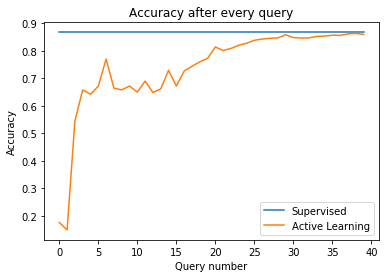

In [34]:
supervised_accuracy = [score for x in range(0,40)]

plt.figure()
plt.plot(np.linspace(0,39,40),supervised_accuracy)
plt.plot(accuracy_list)
plt.title("Accuracy after every query")
plt.xlabel("Query number")
plt.ylabel("Accuracy")
plt.legend(["Supervised", "Active Learning"], loc="lower right")
plt.show()

In [21]:
short_df = df[['question_id','student_answer','student_modified', 'grade','question']]
short_df['status'] = short_df['grade'] >= 3
short_df['status'] = short_df['status'].astype(int)
ques_id_list = list(short_df['question_id'].unique())

Accuracy_dict = {}
n = 0

while n <= 3:
    # FOR ONE BY ONE QUESTION
    ques_df = short_df[short_df['question_id'] == ques_id_list[0]]
    ques_df.reset_index(drop = True,inplace=True)
    

    # counting unique words in every student's answer
    CV = CountVectorizer()
    student_answer_count_vector = CV.fit_transform(ques_df['student_modified'])
    student_answer_count_vector = student_answer_count_vector.toarray()

    X = student_answer_count_vector
    Y = ques_df['status'].values

    #getting the seed index
    classes = ques_df['status'].unique()
    seed_index = []
    for i in classes:
        seed_index.append(ques_df['status'][ques_df['status']==i].index[0])
    print(seed_index)

    act_data = ques_df.copy()
    accuracy_list = []

    # initialising
    train_idx = seed_index
    X_train = X[train_idx]
    y_train = Y[train_idx]

    # generating the pool
    X_pool = np.delete(X, train_idx, axis=0)
    y_pool = np.delete(Y, train_idx)

    act_data = act_data.drop(axis=0,index = train_idx)
    act_data.reset_index(drop = True,inplace=True)


    # initializing the active learner
    # lr = LogisticRegression()
    nb = MultinomialNB()
    learner = ActiveLearner(
    #     estimator = lr,
        estimator = nb,
    #     estimator = RandomForestClassifier(n_estimators=5),
    #     estimator=KNeighborsClassifier(n_neighbors=3),
        X_training=X_train, y_training=y_train
    )

    # pool-based sampling
    n_queries = 8
    for idx in range(n_queries):
        query_idx, query_instance = learner.query(X_pool)
        print("Question number: ", ques_id_list[0])
        print("\nQ: ", act_data.loc[int(query_idx),'question'])
        print("A: ",act_data.loc[int(query_idx),'student_answer'])
        print("Actual grade: ",y_pool[query_idx].reshape(1, ))
    #     print(learner.sigma_)
        print ("Class probabilities: ",learner.predict_proba(X_pool[query_idx].reshape(1, -1)))
        human_label = int(input("\nGive me a grade 0 or 1:"))
        learner.teach(
            X=X_pool[query_idx].reshape(1, -1),
            y=[human_label]
        )

        # remove queried instance from pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)

        act_data = act_data.drop(axis=0,index = query_idx)
        act_data.reset_index(drop=True, inplace=True)

        accuracy_list.append(learner.score(X,Y))
        print('Accuracy after query no. %d: %f' % (idx+1, learner.score(X, Y)))
    
    Accuracy_dict[ques_id_list[0]] = accuracy_list
    ques_id_list.pop(0)
    n += 1

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[0, 5]
Question number:  1.1

Q:  What is the role of a prototype program in problem solving?
A:  It tests the main function of the program while leaving out the finer details. 
Actual grade:  [0]
Class probabilities:  [[0.53108925 0.46891075]]

Give me a grade 0 or 1:0
Accuracy after query no. 1: 0.379310
Question number:  1.1

Q:  What is the role of a prototype program in problem solving?
A:  A prototype program simulates the behaviors of portions of the desired software product to allow for error checking. 
Actual grade:  [1]
Class probabilities:  [[0.50076748 0.49923252]]

Give me a grade 0 or 1:1
Accuracy after query no. 2: 0.758621
Question number:  1.1

Q:  What is the role of a prototype program in problem solving?
A:  To address major issues in the creation of the program.  There is no way to account for all possible bugs in the program  but it is possible to prove the program is tangible. 
Actual grade:  [0]
Class probabilities:  [[0.43627562 0.56372438]]

Give me a grade 0 


Give me a grade 0 or 1:1
Accuracy after query no. 7: 0.862069
Question number:  1.3

Q:  What are the main advantages associated with object-oriented programming?
A:  Object oriented programming allows programmers to use an object with classes that can be changed and manipulated while not affecting the entire object at once.  The classes all hold attrubutes that affect the object. 
Actual grade:  [0]
Class probabilities:  [[0.41419597 0.58580403]]

Give me a grade 0 or 1:0
Accuracy after query no. 8: 0.896552
[0, 7]
Question number:  1.4

Q:  Where do C++ programs begin to execute?
A:  C plus plus programs begin execution at main. 
Actual grade:  [1]
Class probabilities:  [[0.49670628 0.50329372]]

Give me a grade 0 or 1:1
Accuracy after query no. 1: 0.965517
Question number:  1.4

Q:  Where do C++ programs begin to execute?
A:  At the root 
Actual grade:  [0]
Class probabilities:  [[0.4047619 0.5952381]]

Give me a grade 0 or 1:0
Accuracy after query no. 2: 1.000000
Question number: 

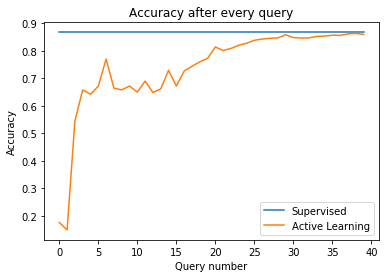

In [35]:
supervised_accuracy = [score for x in range(0,40)]

plt.figure()
plt.plot(np.linspace(0,39,40),supervised_accuracy)
plt.plot(accuracy_list)
plt.title("Accuracy after every query")
plt.xlabel("Query number")
plt.ylabel("Accuracy")
plt.legend(["Supervised", "Active Learning"], loc="lower right")
plt.show()

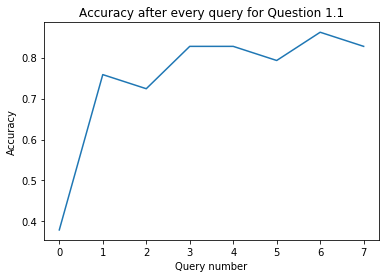

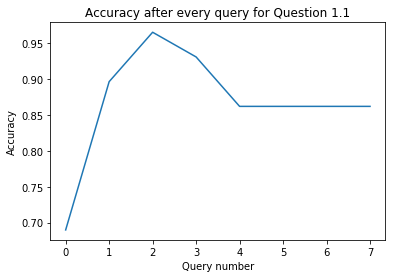

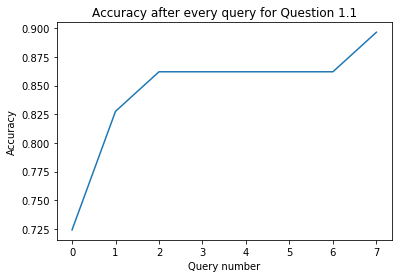

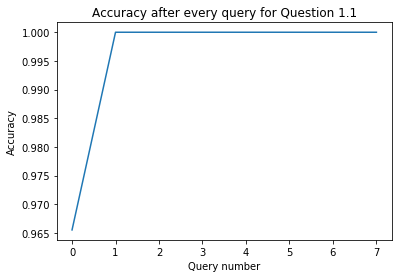

In [39]:
for i in [1.1,1.2,1.3,1.4]:
    plt.figure()
    plt.plot(np.linspace(0,7,8), Accuracy_dict[i])
    plt.title("Accuracy after every query for Question 1.1")
    plt.xlabel("Query number")
    plt.ylabel("Accuracy")
    plt.show()